In [1]:
#from plant_disease import *
from PyILP import *
from Main_PyGol_Initial_Version_2023_04_02_1 import *
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sys
import csv 
import sys
import warnings
import random
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import  svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
warnings.filterwarnings("ignore")
sys_random = random.SystemRandom()
def data_split(dict_1,label):
    dict_2={}
    for i in label:
        dict_2[i]=dict_1[i]
    return dict_2


def data_generation_gilps(file_name = "gilps_example.pl", pos_example= [], 
                          neg_eamples = []):
    string_list = []
    if pos_example:
        for i in pos_example:
            string_1 = "example("+i[0:-1]+","+"1)."
            #print(string_1)
            string_list.append(string_1)
    if neg_eamples:
        for i in neg_eamples:
            string_1 = "example("+i[0:-1]+","+"-1)."
            #print(string_1)
            string_list.append(string_1)
    file_object = open(file_name, 'w')
    for i in string_list:
        file_object.write(i + "\n")
    file_object.close()
def gilps_main_file(file_name = "gilps_ex.pl", modes = "modes.pl", 
                    example_file = "gilps_example.pl", bk_file = "BK.pl"):
    file_object = open(file_name, 'w')
    f = open(modes)
    for line in f.read().splitlines():
            if 'modeh' in line or 'modeb' in line:
                #print(line)
                file_object.write(line+"\n")
    
    file_object.write(":- [" +bk_file.split(".")[0] + "].\n")
    file_object.write(":- [" +example_file.split(".")[0] + "].\n")
    file_object.close()


def read_hypothesis_gilps(file_name = "theory_gilps_ex.pl"):
    f = open(file_name)
    H=[]
    
    for line in f.read().splitlines():
        string_2 = ""
        list_1 = line.split("],")[0].split('[')[-1]
        #print(list_1)
        list_2 = list_1.split('),')
        #print(list_2)
        for i in list_2[1:]:
            if i[-1]!=')':
                string_1 = i+")"
                string_2 = string_2 + string_1 + ","
            else:
                string_2 = string_2 + i + ","
        
        clause = list_2[0] + ")" + ":-" + string_2[0:-1]+"."
        H.append(clause)
        #print(clause)
    return H





def prepare_data_model(file_name="BK.csv",n_classes=10, current_class=0, n_pos=25, n_neg=3, 
                          fixed_neg=False, neg_count=10):
    read_csv = pd.read_csv(file_name)
    #print(read_csv.columns)
    df = pd.DataFrame(read_csv)
    #print(df)
    #scaler = StandardScaler() #MinMaxScaler()#feature_range=(1, 10)
    #df[feature_col] = scaler.fit_transform(df[feature_col])
    target_values = df.label.unique()
    pos_examples_temp=df.loc[df['label'] == current_class]
    pos_examples_temp_id = pos_examples_temp.id.unique()
    #print(list(pos_examples_temp_id), n_pos)
    pos_examples=sys_random.sample(list(pos_examples_temp_id), n_pos)
    #print(pos_examples)
    frames=[]
    pos_examples_ilp=[]
    for i in pos_examples:
        pos_rslt_df = df.loc[df['id'] == int(i)]
        pos_rslt_df['label'] = pos_rslt_df['label'].replace(current_class,'1')
        frames.append(pos_rslt_df)
        #for i in pos_examples:
        string="target(e_"+str(i)+")."
        pos_examples_ilp.append(string)
    #print(pos_examples_ilp)
    class_id={}
    neg_examples_set=[]
    for i in target_values:
        if i!=current_class:
            neg_examples_temp=df.loc[df['label'] == i]
            neg_examples_temp_id = neg_examples_temp.id.unique()
            neg_examples=sys_random.sample(list(neg_examples_temp_id), n_neg)
            neg_examples_set=neg_examples_set+neg_examples
            for j in neg_examples:
                class_id[j]=i
    #print(neg_examples_set)
    
    if fixed_neg:
        neg_examples_set=sys_random.sample(neg_examples_set, neg_count)
    
    #print("--",len(neg_examples_set))
    neg_examples_ilp=[]
    for i in neg_examples_set:
        neg_rslt_df = df.loc[df['id'] == int(i)]
        neg_rslt_df['label'] = neg_rslt_df['label'].replace(class_id[i],'0')
        frames.append(neg_rslt_df)
        #for i in pos_examples:
        string="target(e_"+str(i)+")."
        neg_examples_ilp.append(string)
    #print(neg_examples_ilp)
    final_frame=pd.concat(frames)
    #print(final_frame)
    return pos_examples_ilp, neg_examples_ilp, final_frame, pos_examples, neg_examples_set

In [2]:
def prepare_test_train(csv_file, test_size=0.25):
    read_csv = pd.read_csv(csv_file)
    df = pd.DataFrame(read_csv)
    
    feature_col=df.columns[1:-1]
    scaler = MinMaxScaler()#StandardScaler() #MinMaxScaler()
    df[feature_col] = scaler.fit_transform(df[feature_col])
    target_values = df.label.unique()
    #print(target_values)
    test_df=[]
    train_df=[]
    test_count=0
    train_count=0
    for i in target_values:
        new_df = df.loc[df['label'] == i]
        ids=new_df['id']
        #c=np.split(ids, length_div)
        
        split_limit = int(len(ids)*(1-test_size))
        
        #print(split_limit)
        
        #print(c)
        train=ids[:split_limit]
        test=ids[split_limit:]
        #print(len(train), len(test))
        
        for id_1 in train:
            new_df_1 = df.loc[df['id'] == id_1].replace(id_1,train_count)
            train_df.append(new_df_1)
            train_count=train_count+1
        for id_1 in test:
            new_df_2 = df.loc[df['id'] == id_1].replace(id_1,test_count)
            test_df.append(new_df_2)
            test_count=test_count+1
    train_data=pd.concat(train_df)
    test_data=pd.concat(test_df)
    return train_data, test_data, target_values

In [3]:
csv_file = "fundus_image.csv"
csv_file_train="Train.csv"
csv_file_test="Test.csv"
bk_File = "BK.pl"


In [4]:
Tr, Ts, Tv= prepare_test_train(csv_file,test_size=0.4)
Tr.to_csv(csv_file_train, index=False)
Ts.to_csv(csv_file_test, index=False)

In [5]:
#PyGolM
min_pos=2
max_neg=15
max_literals=2
key_size=1
#Metagol_NT
num_pos=10
num_neg=10
max_run=20
metagol_settings="mode_mil.pl"
#Aleph
aleph_settings="aleph_modes.pl"

In [6]:
data = pd.read_csv(csv_file)
feature_col=data.columns[1:-1]
target=data.columns[-1]
X_train=data[feature_col]
y_train=data[target]

In [7]:

pygol_1,  DT_1,NB_1,SVM_1,Per_1 , MLP_1, LR_1, LDA_1, KNN_1, RF_1, MIL_1, aleph_1, toplog_1 = [], [],[], [],[],[],[],[],[],[],[],[],[]

In [8]:
background=prepare_ilp_data(data,feature_col, meta_information="meta_data.info", 
                               default_div=3, conditions={}, data_binning=True, bin_size=100)
examples=prepare_examples(data,target)
const=read_constants_meta_info()

total_examples=[]
for i in examples:
    #c=read_example(i)
    #print(c)
    total_examples=total_examples+read_example(i)
P, N = bottom_clause_generation(file="BK.pl", constant_set = const,  container = "memory",
                                positive_example=total_examples,
                                negative_example=[])

binning
[0.0, 1319.806424, 2639.612848, 3959.419272, 5279.225696, 6599.032120000001, 7918.838544, 9238.644968, 10558.451392, 11878.257816000001, 13198.064240000002, 14517.870664000002, 15837.677088, 17157.483512000003, 18477.289936, 19797.096360000003, 21116.902784, 22436.709208, 23756.515632000002, 25076.322056, 26396.128480000003, 27715.934904, 29035.741328000004, 30355.547752000002, 31675.354176, 32995.1606, 34314.967024000005, 35634.773448, 36954.579872, 38274.386296000004, 39594.19272000001, 40913.999144, 42233.805568, 43553.611992000006, 44873.418416, 46193.22484, 47513.031264000005, 48832.83768800001, 50152.644112, 51472.450536000004, 52792.256960000006, 54112.063384, 55431.869808, 56751.676232000005, 58071.48265600001, 59391.28908, 60711.095504000004, 62030.90192800001, 63350.708352, 64670.514776, 65990.3212, 67310.127624, 68629.93404800001, 69949.740472, 71269.546896, 72589.35332000001, 73909.159744, 75228.966168, 76548.77259200001, 77868.579016, 79188.38544000001, 80508.19186

100%|███████████████████████████████████████████| 72/72 [00:00<00:00, 92.38it/s]


In [9]:
pos_limit=7
list_1=[2,4,6,8,10]
pos_dict ={}
neg_dict = {}
for j in list_1:
    pygol,  DT,NB,SVM,Per , MLP, LR, LDA, KNN, RF,MIL,aleph, toplog = [], [],[],[],[],[],[],[],[],[],[],[],[]
    for i in range(0,20):
        pos, neg, frame, pos_id, neg_id=prepare_data_model(file_name=csv_file_train, n_classes=2,
                                                           current_class=0, 
                                                      n_pos=j, n_neg=5, 
                                                               neg_count=20)#fixed_neg=True, 
        pos_1, neg_1, frame_test, pos_1_id, neg_1_id=prepare_data_model(file_name=csv_file_test,
                                                                        n_classes=2, 
                                                        current_class=0, 
                                                      n_pos=8, n_neg=8, 
                                                        neg_count=27)#fixed_neg=True,
        
        X_train=frame[feature_col]
        y_train=frame[target]
        X_test=frame_test[feature_col]
        y_test=frame_test[target]
        Train_P=data_split(P,pos)
        Train_N=data_split(P,neg)
        
        data_generation_gilps(file_name = "gilps_example.pl",
                              pos_example=pos, neg_eamples=neg)
        
        gilps_main_file(file_name = "gilps_ex.pl", modes = "gilps_modes.pl", 
                    example_file = "gilps_example.pl", bk_file = "bk_gilps.pl")
        
        os.system("sh run_script.sh")
        
        hypo_gilps = read_hypothesis_gilps(file_name = "theory_gilps_ex.pl")
        metrics_toplog=evaluate_theory_prolog(hypo_gilps,"BK.pl",pos_1, 
                                                      neg_1)
        #time.sleep(30)
        
        toplog.append(metrics_toplog.accuracy)
        
        
        model_pygol, pos_dict, neg_dict  = pygol_learn(Train_P, Train_N, min_pos=1, constant_set=const,
                                         max_neg= 0 , key_size=1, 
                                        max_literals=4, hypo_set_dic= pos_dict ,
                                                      rule_set_dic = neg_dict )#,  verbose=True
        metrics_pygol=evaluate_theory_prolog(model_pygol.hypothesis,"BK.pl",pos_1, 
                                                      neg_1)#, verbose=True


        pygol.append(metrics_pygol.accuracy)
       


        
        
        model_mil=metagolnt_learn(file="BK.pl", test_size=0, positive_example=pos,
                  negative_example=neg, shuffle=False, verbose=True,
                            settings="mode_mil.pl", num_pos=1, num_neg=2, max_run=3)
        metrics_mil=evaluate_theory_prolog(model_mil.hypothesis,"BK.pl",pos_1, neg_1)
        MIL.append(metrics_mil.accuracy)
        model_aleph= aleph_learn(file="BK.pl", positive_example=pos, negative_example=neg, test_size=0,
                                        settings="aleph_modes.pl")#, verbose=True
        
        if len(model_aleph.hypothesis)>0:
            metrics_aleph=evaluate_theory_prolog(model_aleph.hypothesis,"BK.pl",pos_1,
                                                 neg_1)
            aleph.append(metrics_aleph.accuracy)

        else:
            aleph.append(0.50)
        
        dt = DecisionTreeClassifier().fit(X_train, y_train)
        clf1 = GaussianNB().fit(X_train, y_train)
        clf2 = svm.SVC().fit(X_train, y_train)
        clf3 = Perceptron().fit(X_train, y_train)
        clf4 = MLPClassifier().fit(X_train, y_train)
        clf5=LogisticRegression().fit(X_train, y_train)
        clf6=LinearDiscriminantAnalysis().fit(X_train, y_train)
        clf7=KNeighborsClassifier().fit(X_train, y_train)
        clf8=RandomForestClassifier().fit(X_train, y_train)
        test_score_DT=accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))


        test_score_NB=accuracy_score(y_true=y_test, y_pred=clf1.predict(X_test))
        test_score_svm=accuracy_score(y_true=y_test, y_pred=clf2.predict(X_test))
        test_score_per=accuracy_score(y_true=y_test, y_pred=clf3.predict(X_test))
        test_score_mlp=accuracy_score(y_true=y_test, y_pred=clf4.predict(X_test))
        test_score_LR=accuracy_score(y_true=y_test, y_pred=clf5.predict(X_test))
        test_score_LDA=accuracy_score(y_true=y_test, y_pred=clf6.predict(X_test))
        test_score_KNN=accuracy_score(y_true=y_test, y_pred=clf7.predict(X_test))
        test_score_RF=accuracy_score(y_true=y_test, y_pred=clf8.predict(X_test))
        pygol.append(metrics_pygol.accuracy)
        MIL.append(metrics_mil.accuracy)
        DT.append(test_score_DT)
        NB.append(test_score_NB)
        Per.append(test_score_per)
        SVM.append(test_score_svm)
        MLP.append(test_score_mlp)
        LR.append(test_score_LR)
        LDA.append(test_score_LDA)
        KNN.append(test_score_KNN)
        RF.append(test_score_RF)
    pygol_1.append(pygol)
    DT_1.append(DT)
    NB_1.append(NB)
    Per_1.append(Per)
    SVM_1.append(SVM)
    MLP_1.append(MLP)
    LR_1.append(LR)
    LDA_1.append(LDA)
    KNN_1.append(KNN)
    RF_1.append(RF)
    MIL_1.append(MIL)
    aleph_1.append(aleph)
    toplog_1.append(toplog)

% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,10558.451392).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4

100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-torta(A,B),gteq(B,22436.709208).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 6                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | 0.500 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.750 |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']
2 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specifi

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)']
2 ['target(A):-torta(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
|

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,10558.451392).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
0.438
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.438 |
+-------------+-------+
| Precision   | 0.400 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.625 |
+-------------+-------+
| F1 Score    | 0.308 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


+----------+ Hypothesis +----------+
['target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']
2 ['target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+--------

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,17157.483512000003)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.545 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']
2 ['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+------

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-torta(A,B),gteq(B,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.545 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)']
2 ['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+--

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,11878.257816).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)']
2 ['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-torta(A,

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-torta(A,B),tortv(A,C),gteq(B,10558.451392),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 7                |
+---------------------+------------------+------------------+
0.438
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.438 |
+-------------+-------+
| Precision   | 0     |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
1 ['target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.857
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-cr

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']


2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 9

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-torta(A,B),gteq(B,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.07s/it]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sen

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 4                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | 0.500 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.800 |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


1 ['target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 8                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


+----------+ Hypothesis +----------+
['target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
1 ['target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
1 ['target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2      

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, 

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4071.35it/s]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)']
2 ['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score 

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-torta(A,B),gteq(B,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity |

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,11878.257816).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)']
2 ['target(A):-torta(A, B),gteq(B, 22436.709208)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-torta(A,

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 6                |
+---------------------+------------------+------------------+
0.375
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.375 |
+-------------+-------+
| Precision   | 0     |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 0.750 |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 25266.89it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 10558.451392),tortv(A, C)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


2 ['target(A):-torta(A, B),gteq(B, 10558.451392),tortv(A, C)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-torta(A, B),gteq(B, 10558.451392),tortv(A, C)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,5279.225696).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
|

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34492.63it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']


2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'targe

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.545 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 32363.46it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']


2 ['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)']
+----------+ Testing +

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


2 ['target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-torta(A,B),gteq(B,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
0.438
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.438 |
+-------------+-------+
| Precision   | 0.400 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.625 |
+-------------+-------+
| F1 Score    | 0.308 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34435.99it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']


2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
2 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'targe

+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.857 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 7        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.714 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
0.438
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.438 |
+-------------+-------+
| Precision   | 0.400 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.625 |
+-------------+-------+
| F1 Score    | 0.308 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']
4 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
|

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,27715.934904).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 8                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 28649.62it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-tortv(A, B),gteq(B, 5279.225696),lteq(B, 6599.032120000001)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)']


3 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-tortv(A, B),gteq(B, 5279.225696),lteq(B, 6599.032120000001)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.889
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.889 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+------------

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,31675.354176).', 'target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.545 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 50533.78it/s]

+----------+ Hypothesis +----------+
['target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)']


4 ['target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
4 ['t

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,15837.677088).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 8                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9125.99it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']


4 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+--

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 6                |
+---------------------+------------------+------------------+
0.438
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.438 |
+-------------+-------+
| Precision   | 0.333 |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 0.750 |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 45789.34it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']


4 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+----

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,10558.451392).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 6                |
+---------------------+------------------+------------------+
0.438
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.438 |
+-------------+-------+
| Precision   | 0.333 |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 0.750 |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 35484.81it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']


3 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.889
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.889 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,13198.06424).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 56375.05it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)']


3 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
3 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A)

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.778 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),gteq(B,31675.354176).', 'target(A):-tortv(A,B),gteq(B,130660.835976).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.545 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 55480.21it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']


3 ['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
3 ['target(A):-torta(A, B),gteq(B, 15837.677088

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.778 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+----------


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 8                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+
['A(A):-B(B, C)&

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34435.99it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)']


4 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,13198.06424).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 54189.97it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)']


3 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
3 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A)

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.778 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 6                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.600 |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 0.750 |
+-------------+-------+
| F1 Score    | 0.462 |
+-------------+-------+
['A(A):-B(B, C)&

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34836.41it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002),lteq(B, 31675.354176)']


4 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002),lteq(B, 31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+--

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,31675.354176).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 7                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | 0.500 |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.200 |
+-------------+-------+


['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)']
4


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9246.70it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002),lteq(B, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']


4 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002),lteq(B, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-----

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,13198.06424).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 8                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33662.15it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']


4 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+---------

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 8                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33770.56it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']


4 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Sc

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | 0.500 |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 0.625 |
+-------------+-------+
| F1 Score    | 0.429 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41943.04it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']


4 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).', 'target(A):-tortv(A,B),torta(A,C),gteq(C,15837.677088),gteq(B,14517.870664).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 8                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, E

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33235.37it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),gteq(B, 5279.225696),lteq(B, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)']


3 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),gteq(B, 5279.225696),lteq(B, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.889
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.889 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-tortv(A,B),gteq(B,130660.835976).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 8                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 51909.70it/s]

+----------+ Hypothesis +----------+
['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),lteq(B, 10558.451392),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)']


3 ['target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),lteq(B, 10558.451392),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.889
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.889 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------------+-------+
3 ['

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,31675.354176).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 8                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D,

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 32115.65it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']


3 ['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
3 ['target(A):-avr(A, B),

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.778 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.556 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,22436.709208).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-B(B, C)&C(D, 

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16320.25it/s]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
3 ['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| A

+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.778 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


3 ['target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, 

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 37650.84it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']


3 ['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------+---+
| Specificity | 1 |
+-------------+---+
| F1 Score    | 1 |
+-------------+---+
3 ['target(A):-torta(A, B),gteq(B, 15837.677088),

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.667 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|        n = 9        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.778 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),tortv(A,C),gteq(B,15837.677088),gteq(C,14517.870664).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+--

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33879.68it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)']


4 ['target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.909
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.909 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.833 |
+-----------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.818 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.667 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,14517.870664).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Sc

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 52958.38it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)']


5 ['target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.455 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,11878.257816).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 46500.04it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


5 ['target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity 

+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+--

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13148.29it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-tortv(A, B),lteq(B, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


5 ['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-tortv(A, B),lteq(B, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
| 


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 43151.28it/s]

+----------+ Hypothesis +----------+
['target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-bstdv(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']


4 ['target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-bstdv(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.909
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.909 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.833 |
+-------------+-----

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
['A(A):-B(B, C)&

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16107.16it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968)']
5 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+--

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.818 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.667 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 7                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.800 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.615 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34100.03it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)']


5 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-----

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,17157.483512000003).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 30218.33it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


5 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+-------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.818 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.667 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 7                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.800 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.615 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-torta(A,B),gteq(B,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 6                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.714 |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Specificity | 0.750 |
+--

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34267.19it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)', 'target(A):-tortv(A, B),lteq(B, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']


6 ['target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)', 'target(A):-tortv(A, B),lteq(B, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+--

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.455 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-torta(A,B),gteq(B,18477.289936).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 8                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.769 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 29746.84it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


5 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensi

+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.818 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.667 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,130660.835976).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 56679.78it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


5 ['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.455 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,22436.709208).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.625 |
+-------------+-------+
| F1 Score    | 0.706 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 43329.59it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']


5 ['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sen

+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+--

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 48099.82it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)']


5 ['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+----------


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+---

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33130.36it/s]


+----------+ Hypothesis +----------+
['target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']
6 ['target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.455 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,14517.870664).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 7                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 0.833 |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.714 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):-

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 55924.05it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']


5 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------+---+
| Sensitivity | 1 |
+----

+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 31488.77it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)']


5 ['target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |
+-------------+---+
| Precision   | 1 |
+-------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-tortv(A,B),torta(A,C),gteq(B,27715.934904),gteq(C,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 8                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.625 |
+---------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 42886.54it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),lteq(B, 10558.451392),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']


5 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),lteq(B, 10558.451392),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.909
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.909 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.83

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,22436.709208).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

[]
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 0                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.455 |
+-------------+-------+
| Precision   | None  |
+-------------+-------+
| Sensitivity | 0     |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0     |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),torta(A,C),gteq(C,17157.483512),gteq(B,15837.677088).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&D(F, G)&E(H, I)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)&D(F, G)']
4
['A(A):-B(B, C)', 'A(A):-B(B, C)&C(D, E)', 'A(A):-B(B, C)&C(D, E)&D(F, G)', 'A(A):

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 57932.38it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)']


4 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.909
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.909 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.833 |
+-------------+--

+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.818 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.667 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


4 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 7                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.800 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.615 |
+-------------+-------+
['A(A):-B(B, C)&C(D, E)&

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 29330.80it/s]

+----------+ Hypothesis +----------+
['target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


4 ['target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.909
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.909 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.833 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-crae(A,col_0_4),crae(A,col_0_4).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,130660.835976).', 'target(A):-torta(A,B),tortv(A,C),gteq(C,27715.934904),gteq(B,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 43419.30it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


4 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.909
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.909 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.833 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score 

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.545 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.167 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.286 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 11        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.636 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.333 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.500 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 6                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.714 |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Sp

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,10558.451392).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,14517.870664).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 7                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   |

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41610.16it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+-------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+----------


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Spec

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5701.88it/s]


+----------+ Hypothesis +----------+
['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)']
7 ['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 15837.6

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,13198.06424).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 6                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.714 |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Specificity | 0

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 48321.47it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 27715.934904)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),lteq(B, 10558.451392)']


7 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 27715.934904)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),lteq(B, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+=

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specificity | 1     |
+-------------+---

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 38269.20it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 17157.483512000003),lteq(B, 18477.289936),tortv(A, C)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']


6 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 17157.483512000003),lteq(B, 18477.289936),tortv(A, C)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.923
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.923 |
+-------------+-------+
| Pre

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,11878.257816).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 7                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 0.875 |
+-------------+-------+
| Sensitivity | 0.875 |
+-------------+-----

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 52958.38it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-bstdv(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)']


7 ['target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-bstdv(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+----------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33026.02it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)']


7 ['target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+---------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,17157.483512000003).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,31675.354176).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 6                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.714 |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Spe

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 34100.03it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 31675.354176),lteq(B, 32995.1606)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


7 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 31675.354176),lteq(B, 32995.1606)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+----

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 7                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.800 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.615 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,27715.934904).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,31675.354176).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 8                |
+---------------------+------------------+------------------+
0.938
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.938 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.875 |
+---

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 42111.49it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 31675.354176)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']


7 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 31675.354176)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 11878.257816000001)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metric    | # |
+=============+===+
| Accuracy    | 1 |


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Spec

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 38621.58it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,14517.870664).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 6                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 0.750 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 53227.21it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']


7 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+-------------+---+
|   Metr

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 4                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.800 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 6                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.750 |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-torta(A,B),gteq(B,18477.289936).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 6                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.714 |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Specificity |

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 37516.14it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002),lteq(B, 31675.354176)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)', 'target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 17157.483512000003)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002),lteq(B, 31675.354176)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)', 'target(A):-avr(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 17157.483512000003)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 7                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.800 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.615 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+----

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 46397.17it/s]

+----------+ Hypothesis +----------+
['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)']


7 ['target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+---------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,27715.934904).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 7                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 0.800 |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 52038.51it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)']


6 ['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 11878.257816000001)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.923
+-------------+-------+
|   Metric    |   #   |
+====

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,27715.934904).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,14517.870664).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 8                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.688 |
+-------------+-------+
| Precision   | 1     |
+-------------+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17878.53it/s]


+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)']
7 ['target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crv

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-tortv(A,B),gteq(B,31675.354176).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-----

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 49113.63it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)']


7 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+--------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,130660.835976).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,15837.677088).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,30355.547752).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 6                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | 0.500 |
+--------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41692.88it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-bstdv(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+------------------+
1.0
+----------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 8                |
+---------------------+------------------+------------------+
0.625
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.625 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-bstda(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,9238.644968).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 35787.58it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+--------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 7                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.462 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.125 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.222 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,27715.934904)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
[best clause]+----------+ Testing +----------+
+---------------------+------------------+----------


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,30355.547752).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,17157.483512).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,27715.934904).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 3                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 5                | 5                |
+---------------------+------------------+------------------+
0.5
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.500 |
+-------------+-------+
| Precision   | 0.500 |
+-------------+-------+
| Sensitivity | 0.375 |
+-------------+-------+
| Specif

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 28807.03it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)']


6 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.923
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.923 |
+-------------+-------+
| 

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,17157.483512000003).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A) :-   torta(A,B), lteq(B,10558.451392).']


[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 7                |
+---------------------+------------------+------------------+
0.562
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.562 |
+-------------+-------+
| Precision   | 0.667 |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.364 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


5 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-avr(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+----

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 55333.83it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


7 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0                | 5                |
+---------------------+------------------+----------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.538 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.250 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.400 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 13        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.692 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 7                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 0.875 |
+-------------+-------+
| Sensit

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 58254.22it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0      

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,17157.483512

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,13198.06424).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 39643.71it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']


9 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0       

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-torta(A,B),tortv(A,C),gteq(C,27715.934904),gteq(B,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 8                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 51150.05it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


7 ['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+--------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.600 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.400 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 6                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.778 |
+-------------+-------+
| Sensitiv

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 44810.94it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+------------------+------------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,30355.547752000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,23756.515632

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 6                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 0.750 |
+-------------+-------+

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 37583.37it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 31675.354176),lteq(B, 32995.1606)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-tortv(A, B),lteq(B, 13198.064240000002)']


9 ['target(A):-torta(A, B),lteq(B, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 31675.354176),lteq(B, 32995.1606)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 18477.289936)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-tortv(A, B),lteq(B, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0          

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,15837.677088).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,15837.677088).', 'target(A):-tortv(A,B),torta(A,C),gteq(B,27715.934904),gteq(C,22436.709208).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision  

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 37449.14it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']


7 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
0.867
+-------------+-------+
|   Metric 

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,14517.870664000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.600 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.400 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


6 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-tortv(A,B),gteq(B,5279.225696).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 8                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.625 |
+-------------+-------+
| Specificity | 

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 59074.70it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']


7 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),lteq(B, 15837.677088),tortv(A, C)', 'target(A):-torta(A, B),lteq(B, 19797.096360000003),tortv(A, C)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-tortv(A, B),gteq(B, 130660.83597600002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 9238.644968)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 8                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 5                |
+---------------------+------------------+------------------+
0.867
+-------------+-------+
|   Metric   

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,130660.83597600002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.600 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.400 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.500 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.667 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 3                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 0.700 |
+-------------+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 40960.00it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 31675.354176)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']


9 ['target(A):-torta(A, B),gteq(B, 15837.677088),tortv(A, C)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 31675.354176)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+--------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,22436.709208).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,22436.709208)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,23756.515632

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-tortv(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 6                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.778 |
+-------------+-------+
| Sensit

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 56375.05it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+------------------+------------------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


8 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,27715.934904).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,31675.354176).', 'target(A):-torta(A,B),tortv(A,C),gteq(B,10558.451392),gteq(C,5279.225696).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 6                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 33879.68it/s]

+----------+ Hypothesis +----------+
['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 31675.354176),lteq(B, 32995.1606)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']


8 ['target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 31675.354176),lteq(B, 32995.1606)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-tortv(A, B),lteq(B, 29035.741328000004)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 9                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 5                |
+---------------------+------------------+------------------+
0.933
+---------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.600 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.400 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-----------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41610.16it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 30355.547752000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 0      

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,17157.483512

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-avr(A,B),torta(A,C),gteq(C,10558.451392).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-avr(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 6                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.778 |
+-------------+-------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 52958.38it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+-------

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 6                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 0.750 |
+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 28966.19it/s]


+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
9 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 6                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 0.750 |
+-------------+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 47233.15it/s]

+----------+ Hypothesis +----------+
['target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-torta(A, B),gteq(B, 18477.289936),lteq(B, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


9 ['target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 15837.677088)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 32995.1606)', 'target(A):-torta(A, B),gteq(B, 18477.289936),lteq(B, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 27715.934904),lteq(B, 29035.741328000004)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+----

% learning target/1
% clauses: 1
target(A):-torta(A,B),gteq(B,17157.483512000003).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-torta(A,B),gteq(B,17157.483512000003)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,17157.483512

+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 7                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.857 |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 0.875 |
+-------------+-------+
| F1 Score    | 0.800 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-avr(A,B),torta(A,C),gteq(C,22436.709208).', 'target(A):-torta(A,B),gteq(B,17157.483512).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-bstdv(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,11878.257816).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 7                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 0.875 |
+-------------+-------+

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 53362.65it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)', 'target(A):-tortv(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 10558.451392),lteq(B, 11878.257816000001)', 'target(A):-tortv(A, B),gteq(B, 15837.677088),lteq(B, 17157.483512000003)', 'target(A):-bstda(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 15837.677088)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+-

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,17157.483512

[best clause]+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.750 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.857 |
+-------------+-------+


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,9238.644968).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,10558.451392).', 'target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,13198.06424).', 'target(A):-bstdv(A,B),torta(A,C),gteq(C,17157.483512).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 2                | 8                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sens

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17360.53it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968)']
9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-bstdv(A, B),lteq(B,

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,13198.064240000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,27715.934904).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,130660.83597600002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,13198.064240000002)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,10558.451392).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,23756.515632


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 6                |
+---------------------+------------------+------------------+
0.812
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.812 |
+-------------+-------+
| Precision   | 0.778 |
+-------------+------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 48545.19it/s]


+----------+ Hypothesis +----------+
['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 6599.032120000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 15837.677088)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 130660.83597600002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)']
9 ['target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 18477.289936)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 1451

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,15837.677088)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+=====

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-torta(A,B),gteq(B,15837.677088).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,11878.257816).', 'target(A):-tortv(A,B),gteq(B,13198.06424).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,15837.677088).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,130660.835976).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 8                |
+---------------------+------------------+------------------+
0.75
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.750 |
+-------------+-------+
| Precision   | 1     |
+------------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16057.83it/s]


+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-torta(A, B),gteq(B, 14517.870664000002),tortv(A, C)', 'target(A):-bstda(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 14517.870664000002)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)']
9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 17157.483512000003)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 14517.870664000002)', 'targe

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,31675.354176).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.600 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.400 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,23756.515632000002).', 'target(A) :-   torta(A,B), lteq(B,17157.


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


8 ['target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-torta(A,B),gteq(B,14517.870664).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-crae(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-bstda(A,B),tortv(A,C),gteq(C,15837.677088).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,30355.547752).', 'target(A):-tortv(A,B),torta(A,C),gteq(C,15837.677088),gteq(B,14517.870664).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 5                | 2                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 3                | 6                |
+---------------------+------------------+------------------+
0.688
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Ac

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 32615.12it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']


8 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-bstdv(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 19797.096360000003)', 'target(A):-avr(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 17157.483512000003)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 5279.225696)', 'target(A):-crae(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 131980.6424)', 'target(A):-torta(A, B),gteq(B, 9238.644968),tortv(A, C)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 9                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1     

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,30355.547752000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,11878.257816000001).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 2                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 8                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.467 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.200 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.333 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,11878.257816000001)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 4                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 6                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.600 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.400 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.571 |
+-------------+-------+
2 ['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002


% Restoring file /usr/lib/Yap/startup.yss
YAP 6.2.2 (x86_64-linux): Wed Jul 15 05:25:26 UTC 2015


7 ['target(A):-tortv(A,B),gteq(B,11878.257816).', 'target(A):-torta(A,B),gteq(B,22436.709208).', 'target(A):-bstda(A,B),torta(A,C),gteq(C,15837.677088).', 'target(A):-torta(A,B),gteq(B,18477.289936).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,5279.225696).', 'target(A):-avr(A,B),torta(A,C),gteq(C,9238.644968).', 'target(A):-avr(A,B),tortv(A,C),gteq(C,15837.677088).']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 7                | 1                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 1                | 7                |
+---------------------+------------------+------------------+
0.875
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.875 |
+-------------+-------+
| Precision   | 0.875 |
+-------------

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 45789.34it/s]

+----------+ Hypothesis +----------+
['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 17157.483512000003)']


9 ['target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 23756.515632000002)', 'target(A):-avr(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 14517.870664000002)', 'target(A):-avr(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 13198.064240000002)', 'target(A):-crve(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 31675.354176)', 'target(A):-crve(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 15837.677088)', 'target(A):-tortv(A, B),gteq(B, 5279.225696)', 'target(A):-tortv(A, B),lteq(B, 131980.6424)', 'target(A):-crae(A, B),gteq(B, 0.0),tortv(A, C),gteq(C, 11878.257816000001)', 'target(A):-crve(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 17157.483512000003)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 10               | 0                |
+---------------------+------------------+------------------+
| N

% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,14517.870664000002).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,5279.225696).


% learning target/1
% clauses: 1
target(A):-tortv(A,B),gteq(B,15837.677088).


+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 1                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 9                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.400 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.100 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.182 |
+-------------+-------+
1 ['target(A):-tortv(A,B),gteq(B,5279.225696)']
+----------+ Testing +----------+
+---------------------+------------------+------------------+
|       n = 16        | Positive(Actual) | Negative(Actual) |
+=====================+==================+======

['target(A) :-   torta(A,B), lteq(B,10558.451392).', 'target(A) :-   torta(A,B), lteq(B,17157.483512000003).', 'target(A) :-   torta(A,B), lteq(B,23756.515632000002).']
+----------+ Learning +----------+
+---------------------+------------------+------------------+
|       n = 15        | Positive(Actual) | Negative(Actual) |
+=====================+==================+==================+
| Positive(Predicted) | 6                | 0                |
+---------------------+------------------+------------------+
| Negative(Predicted) | 4                | 5                |
+---------------------+------------------+------------------+
+-------------+-------+
|   Metric    |   #   |
+=============+=======+
| Accuracy    | 0.733 |
+-------------+-------+
| Precision   | 1     |
+-------------+-------+
| Sensitivity | 0.600 |
+-------------+-------+
| Specificity | 1     |
+-------------+-------+
| F1 Score    | 0.750 |
+-------------+-------+
3 ['target(A) :-   torta(A,B), lteq(B,10558.451392

In [10]:
len(['target(A):-crae(A, B),gteq(B, 0.0),torta(A, C),gteq(C, 10558.451392)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 14517.870664000002)', 'target(A):-tortv(A, B),gteq(B, 23756.515632000002)', 'target(A):-torta(A, B),gteq(B, 9238.644968),lteq(B, 10558.451392),tortv(A, C)', 'target(A):-tortv(A, B),lteq(B, 26396.128480000003)', 'target(A):-crae(A, B),lteq(B, 1319.806424),torta(A, C),lteq(C, 27715.934904)', 'target(A):-bstda(A, B),lteq(B, 1319.806424),tortv(A, C),lteq(C, 19797.096360000003)', 'target(A):-tortv(A, B),gteq(B, 21116.902784),lteq(B, 22436.709208)'])

8

In [11]:
for i in aleph_1:
    print(np.mean(i))

0.5
0.53125
0.6156499999999999
0.6781499999999999
0.8030000000000002


In [12]:
g = globals()
for i in range(1, pos_limit):
    g['npos_{0}'.format(i)] = []
for i in range(1,pos_limit-1):
    g['npos_{0}'.format(i)].append(np.mean(pygol_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(MIL_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(aleph_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(toplog_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(DT_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(NB_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(SVM_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(Per_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(MLP_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(LR_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(LDA_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(KNN_1[i-1]))
    g['npos_{0}'.format(i)].append(np.mean(RF_1[i-1]))
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


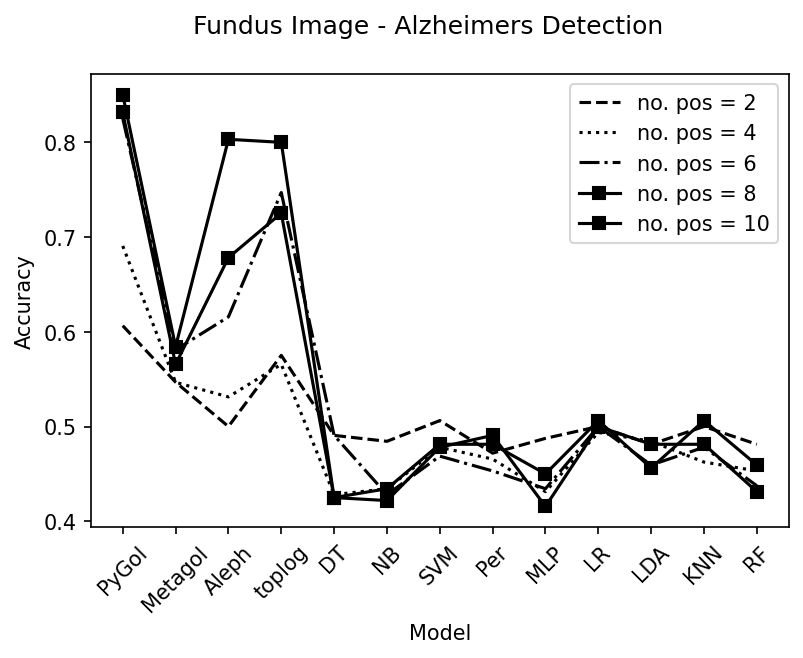

In [13]:
import matplotlib.pyplot as pyplot
stamp = time.strftime("%Y%m%d-%H%M%S") #datetime.now().strftime("%Y%m%d-%H%M%S")
file_name =  "Result_One_Shot_Fundus_"
extension = ".eps"
graph_3 = file_name + stamp + extension  #"Result_One_Shot_Fundus.eps"
fig = pyplot.figure(dpi=150)#pyplot.figure(dpi=150)
fig.suptitle('Fundus Image - Alzheimers Detection')
x = ["PyGol", "Metagol", "Aleph", "toplog" , "DT","NB","SVM","Per" , "MLP", "LR", "LDA", "KNN", "RF"]
ax = fig.add_subplot(111)
pyplot.plot(x, npos_1, 'k--', label ='no. pos = 2')
pyplot.plot(x, npos_2,'k:', label ='no. pos = 4')
pyplot.plot(x, npos_3,'k-.', label ='no. pos = 6')
pyplot.plot(x, npos_4, 'ks-', label ='no. pos = 8')
#plt.plot(x, npos_4, label ='P = 6')
pyplot.plot(x, npos_5, 'ks-', label ='no. pos = 10')
#pyplot.plot(x, npos_6,'ko-', label ='no. pos = 10')
pyplot.xlabel('Model')
pyplot.ylabel('Accuracy')
ax.set_xticklabels(x,rotation=45)
pyplot.legend() 
pyplot.savefig(graph_3)
#pyplot.savefig(graph_3_1)
pyplot.show()


In [14]:
pyplot.savefig(graph_3)

<Figure size 432x288 with 0 Axes>

In [15]:
"""pygol_1.append(pygol)
    
    
   
    LDA_1.append(LDA)
    KNN_1.append(KNN)
    RF_1.append(RF)
    MIL_1.append(MIL)
    aleph_1.append(aleph)"""

pygol_acc_bar= []
pygol_err_bar= []
for i in pygol_1:
    pygol_acc_bar.append(np.mean(i))
    pygol_err_bar.append(np.mean(i))
    
DT_acc_bar= []
DT_err_bar= []
for i in DT_1:
    DT_acc_bar.append(np.mean(i))
    DT_err_bar.append(np.mean(i))
    
NB_acc_bar= []
NB_err_bar= []
for i in NB_1:
    NB_acc_bar.append(np.mean(i))
    NB_err_bar.append(np.mean(i))
    
Per_acc_bar= []
Per_err_bar= []
for i in Per_1:
    Per_acc_bar.append(np.mean(i))
    Per_err_bar.append(np.mean(i))
    
SVM_acc_bar= []
SVM_err_bar= []
for i in SVM_1:
    SVM_acc_bar.append(np.mean(i))
    SVM_err_bar.append(np.mean(i))
    
MLP_acc_bar= []
MLP_err_bar= []
for i in MLP_1:
    MLP_acc_bar.append(np.mean(i))
    MLP_err_bar.append(np.mean(i))
    
LR_acc_bar= []
LR_err_bar= []
for i in LR_1:
    LR_acc_bar.append(np.mean(i))
    LR_err_bar.append(np.mean(i))
    
LDA_acc_bar= []
LDA_err_bar= []
for i in LDA_1:
    LDA_acc_bar.append(np.mean(i))
    LDA_err_bar.append(np.mean(i))
    
KNN_acc_bar= []
KNN_err_bar= []
for i in KNN_1:
    KNN_acc_bar.append(np.mean(i))
    KNN_err_bar.append(np.mean(i))
    
RF_acc_bar= []
RF_err_bar= []
for i in RF_1:
    RF_acc_bar.append(np.mean(i))
    RF_err_bar.append(np.mean(i))

MIL_acc_bar= []
MIL_err_bar= []
for i in MIL_1:
    MIL_acc_bar.append(np.mean(i))
    MIL_err_bar.append(np.mean(i))
    
aleph_acc_bar= []
aleph_err_bar= []
for i in aleph_1:
    aleph_acc_bar.append(np.mean(i))
    aleph_err_bar.append(np.mean(i))
    
toplog_acc_bar= []
toplog_err_bar= []
for i in toplog_1:
    toplog_acc_bar.append(np.mean(i))
    toplog_err_bar.append(np.mean(i))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


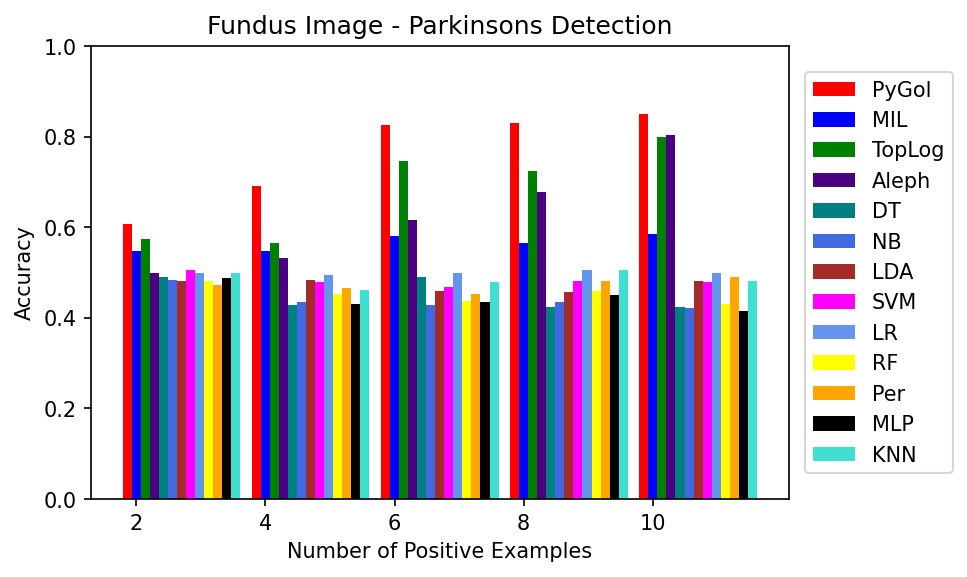

In [17]:
import matplotlib.pyplot as plt
import numpy as np

stamp = time.strftime("%Y%m%d-%H%M%S") #datetime.now().strftime("%Y%m%d-%H%M%S")
file_name =  "Result_OneShot_Fundus_BoxPlot"
extension = ".eps"
graph_3 = file_name + stamp + extension

species = ("2", "4", "6", "8","10")
penguin_means = {
    'PyGol': pygol_acc_bar,
    'MIL' : MIL_acc_bar,
    'TopLog' : toplog_acc_bar,
    'Aleph' : aleph_acc_bar,
    
    
    'DT' : DT_acc_bar,
    'NB' : NB_acc_bar,
    'LDA' : LDA_acc_bar,
    'SVM' : SVM_acc_bar,
    'LR' : LR_acc_bar,
    'RF' : RF_acc_bar,
    'Per' : Per_acc_bar,
    'MLP' : MLP_acc_bar,
    'KNN' : KNN_acc_bar
}
fig = pyplot.figure(dpi=150)#pyplot.figure(dpi=150)

x = np.arange(len(species))  # the label locations
width = 0.07  # the width of the bars
multiplier = 0

c = ['red', 'blue', 'green', 'indigo', 'teal', 'royalblue', 'brown', 'magenta', 
     'cornflowerblue', 'yellow', 'orange', 'black','turquoise']

ax = fig.add_subplot(111)

count=0

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=c[count])
    #ax.bar_label(rects, padding=3)
    multiplier += 1
    count+=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Positive Examples')
ax.set_title('Fundus Image - Parkinsons Detection')
ax.set_xticks(x + width, species)
#ax.legend(loc='best')
ax.legend(loc='right', bbox_to_anchor=(1.25,0.5))
ax.set_ylim(0, 1)

fig.show()
fig.savefig(graph_3)